# Import Data and Train Model


In [216]:
%load_ext tensorboard
import tensorflow as tf
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision.transforms import ToTensor, Lambda


import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
import pandas as pd;
import numpy as np
import math

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Load Data: Create Dataset


### Load Absence Seizure Data


In [150]:
class AbsenceDataset(Dataset):
    def __init__(self, file_path, transform=None, target_transform=None):
        self.x, self.y = self.data_get(file_path)
        self.n_samples = len(self.x)

        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        sample_x, sample_y = self.x[idx], self.y[idx]

        if self.transform:
            sample_x = self.transform(sample_x)

        if self.target_transform:
            sample_y = self.target_transform(sample_y)

        return sample_x.float(), sample_y.float()

    def __len__(self):
        return self.n_samples

    def data_get(self, file_path):
        data = pd.read_csv(file_path)
        x_loaded, y_loaded = [], []
        for index, row in data.iterrows():
            x_loaded.append(np.load(row["data"]))
            y_loaded.append(np.load(row["labels"]))

        continuous_x = np.concatenate(x_loaded, axis=0)
        continuous_y = np.concatenate(y_loaded, axis=0)

        return continuous_x, continuous_y

In [151]:
# Load the dataset

dataset = AbsenceDataset(
    "processed_data/absence/epochs_files.csv",
    transform=torch.tensor,
    target_transform=torch.tensor,
)

### Split Data

70%, 20%, 10%


In [152]:
if (int(len(dataset) * 0.7) + int(len(dataset) * 0.2) + int(len(dataset) * 0.1)) != len(
    dataset
):
    train_set, eval_set, test_set = random_split(
        dataset,
        [
            math.ceil(len(dataset) * 0.7),
            int(len(dataset) * 0.2),
            int(len(dataset) * 0.1),
        ],
    )
else:
    train_set, eval_set, test_set = random_split(
        dataset,
        [int(len(dataset) * 0.7), int(len(dataset) * 0.2), int(len(dataset) * 0.1)],
    )

In [169]:
x_train_reshaped = train_set.dataset.x.reshape(4141, -1)
x_train_reshaped.shape, train_set.dataset.y.shape

((4141, 1000), (4141,))

### Balance Dataset


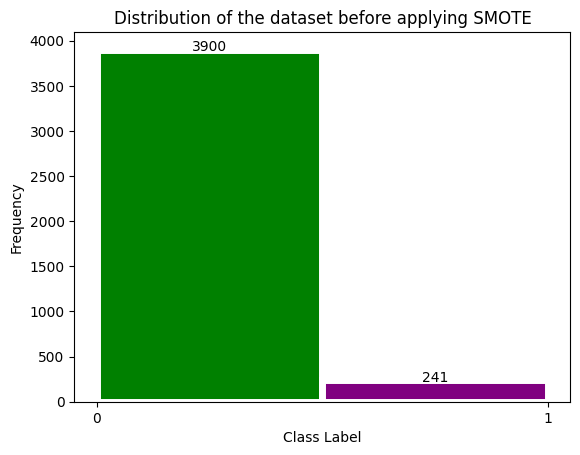

In [171]:
# Plot distribution of the dataset before balancing
# 0 - Background epoch
# 1 - Absence seizure epoch

l = []
for i in train_set.dataset.y:
    l.append(i)

a1, b1, bars = plt.hist(l, bins=2, edgecolor="white", linewidth=5, range=(0, 1))
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title("Distribution of the dataset before applying SMOTE")
plt.xlabel("Class Label")
plt.ylabel("Frequency")
bars[0].set_facecolor("green")
bars[1].set_facecolor("purple")
# put count
for i in bars:
    plt.text(
        i.get_x() + i.get_width() / 2,
        i.get_height() - 50,
        int(i.get_height()),
        ha="center",
        va="bottom",
    )
plt.show()

In [172]:
x_train, y_train = SMOTE(sampling_strategy="minority", random_state=42).fit_resample(
    x_train_reshaped, train_set.dataset.y
)

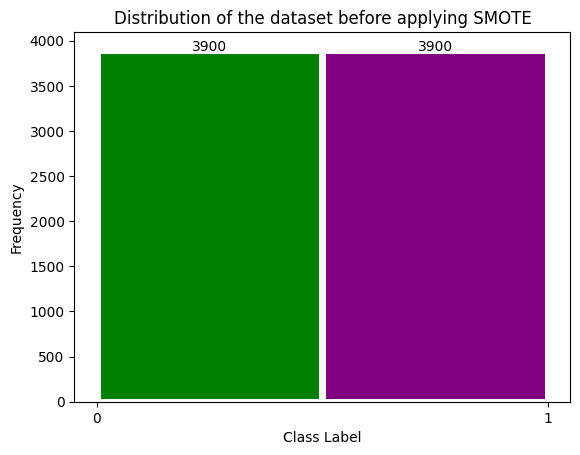

In [173]:
# Plot distribution of the dataset before balancing
# 0 - Background epoch
# 1 - Absence seizure epoch

l = []
for i in y_train:
    l.append(i)

a1, b1, bars = plt.hist(l, bins=2, edgecolor="white", linewidth=5, range=(0, 1))
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title("Distribution of the dataset before applying SMOTE")
plt.xlabel("Class Label")
plt.ylabel("Frequency")
bars[0].set_facecolor("green")
bars[1].set_facecolor("purple")
# put count
for i in bars:
    plt.text(
        i.get_x() + i.get_width() / 2,
        i.get_height() - 50,
        int(i.get_height()),
        ha="center",
        va="bottom",
    )
plt.show()

# DataLoaders


In [176]:
class BalancedDataset(Dataset):
    def __init__(self, data, transform=None, target_transform=None):
        self.x, self.y = data
        self.n_samples = len(self.x)

        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        sample_x, sample_y = self.x[idx], self.y[idx]

        if self.transform:
            sample_x = self.transform(sample_x)

        if self.target_transform:
            sample_y = self.target_transform(sample_y)

        return sample_x.float(), sample_y.float()

    def __len__(self):
        return self.n_samples

In [177]:
new_balanced_train_dataset = BalancedDataset(
    (x_train, y_train), transform=torch.tensor, target_transform=torch.tensor
)

In [182]:
train_dataloader = DataLoader(
    dataset=new_balanced_train_dataset, batch_size=10, shuffle=True
)
eval_dataloader = DataLoader(dataset=eval_set, batch_size=10, shuffle=True)
test_dataloader = DataLoader(dataset=test_set, batch_size=10, shuffle=True)

In [203]:
class AbnormalNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # Input 5 Channels
        self.CNN1 = nn.Conv1d(in_channels=1, out_channels=256, kernel_size=10)
        self.MaxPool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.CNN2 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=10)
        self.MaxPool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.CNN3 = nn.Conv1d(in_channels=512, out_channels=1024, kernel_size=10)
        self.MaxPool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(117, 1024)
        self.dropout1 = nn.Dropout(p=0.3)

        self.fc2 = nn.Linear(1024, 1024)
        self.dropout2 = nn.Dropout(p=0.3)

        # Output Layer
        self.output = nn.Linear(in_features=1024, out_features=1)

    def forward(self, x):
        x = F.relu(self.CNN1(x))
        x = self.MaxPool1(x)

        x = F.relu(self.CNN2(x))
        x = self.MaxPool2(x)

        x = F.relu(self.CNN3(x))
        x = self.MaxPool3(x)

        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))
        x = self.dropout2(x)

        x = self.output(x)
        return x


# Set device to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = AbnormalNeuralNetwork().to(device)

# Set optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Calculate number of parameters in model
n_params = 0
for x in model.parameters():
    n_params += len(torch.flatten(x))
print(f"Number of parameters in model: {n_params:,}")

# Print Model
model

Number of parameters in model: 7,729,409


AbnormalNeuralNetwork(
  (CNN1): Conv1d(1, 256, kernel_size=(10,), stride=(1,))
  (MaxPool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (CNN2): Conv1d(256, 512, kernel_size=(10,), stride=(1,))
  (MaxPool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (CNN3): Conv1d(512, 1024, kernel_size=(10,), stride=(1,))
  (MaxPool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=117, out_features=1024, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (output): Linear(in_features=1024, out_features=1, bias=True)
)

In [186]:
# Test Model on 1 Batch
for i, (inputs, labels) in enumerate(train_dataloader):
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    print(inputs.shape)
    print(outputs.shape)
    print(labels.shape)
    break

torch.Size([1, 1000])
torch.Size([1024, 1])
torch.Size([1])


In [218]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.0
    last_loss = 0.0

    for i, data in enumerate(train_dataloader):

        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()

        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000  # loss per batch
            print("  batch {} loss: {}".format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar("Loss/train", last_loss, tb_x)
            running_loss = 0.0

    return last_loss

In [217]:
EPOCHS = 10  # Number of training iterations
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
writer = SummaryWriter("runs/fashion_trainer_{}".format(timestamp))

for i in range(EPOCHS):
    print(f"EPOCH {i+1}")

    model.train(True)
    avg_loss = train_one_epoch(i, writer)

    running_vloss = 0.0
    model.eval()

    with torch.no_grad():
        for i, data in enumerate(eval_dataloader):
            vinputs, vlabels = data
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += loss.item()

    avg_vloss = running_vloss / (i + 1)
    print("LOSS train {} valid {}".format(avg_loss, avg_vloss))

    writer.add_scalars(
        "Training vs. Validation Loss",
        {"Training": avg_loss, "Validation": avg_vloss},
        epoch_number + 1,
    )
    writer.flush()

    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = "model_{}_{}".format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1


NameError: name 'train_one_epoch' is not defined

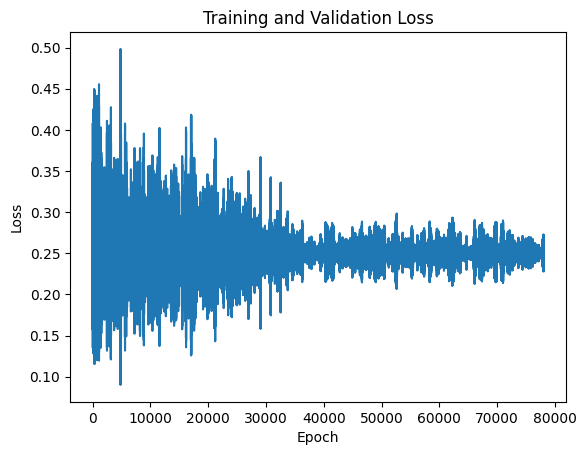

In [202]:
# Plot losses
plt.plot(range(len(losses_train_batch)), losses_train_batch, label="Training Loss")


plt.title("Training and Validation Loss")

plt.xlabel("Epoch")

plt.ylabel("Loss")


plt.show()